# Q3. Bias-Variance Trade-off and Concept Drift

## 1. Bias-Variance Trade-off Visualization

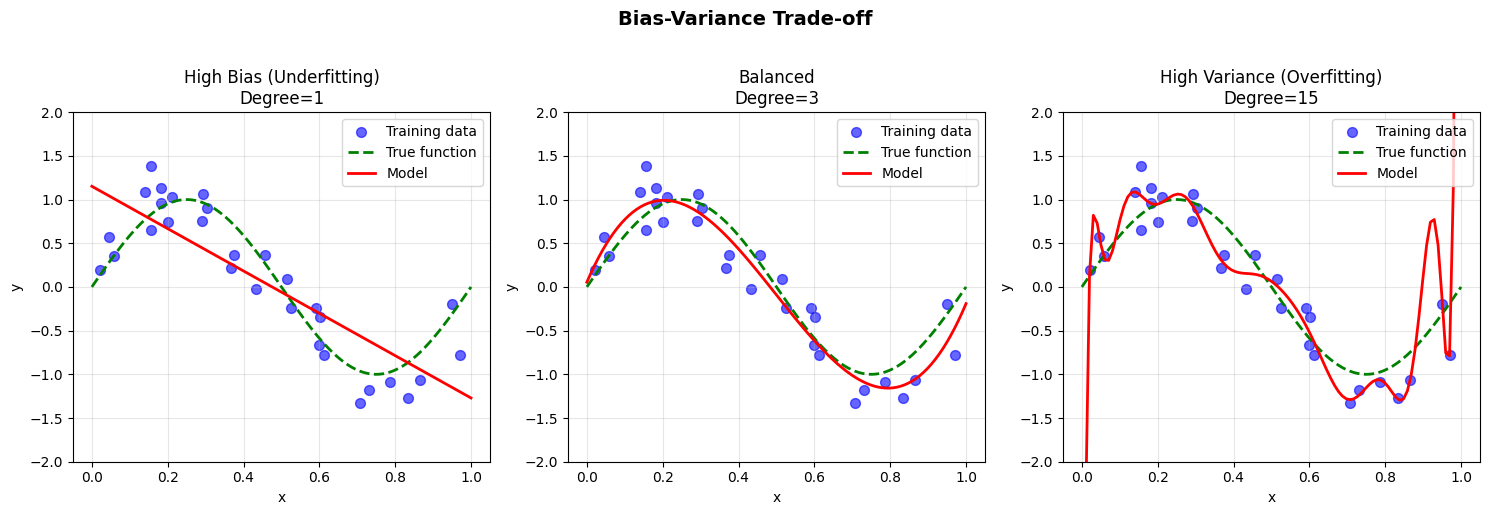

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

def true_function(x):
    return np.sin(2 * np.pi * x)

np.random.seed(42)
n_samples = 30
X = np.random.uniform(0, 1, n_samples)
y = true_function(X) + np.random.normal(0, 0.3, n_samples)

X_test = np.linspace(0, 1, 100)
y_true = true_function(X_test)

degrees = [1, 3, 15]
titles = ['High Bias (Underfitting)\nDegree=1', 'Balanced\nDegree=3', 'High Variance (Overfitting)\nDegree=15']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, degree, title in zip(axes, degrees, titles):
    model = Pipeline([('poly', PolynomialFeatures(degree=degree)), ('linear', LinearRegression())])
    model.fit(X.reshape(-1, 1), y)
    y_pred = model.predict(X_test.reshape(-1, 1))
    
    ax.scatter(X, y, c='blue', alpha=0.6, label='Training data', s=50)
    ax.plot(X_test, y_true, 'g--', linewidth=2, label='True function')
    ax.plot(X_test, y_pred, 'r-', linewidth=2, label='Model')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.set_ylim(-2, 2)
    ax.grid(True, alpha=0.3)

plt.suptitle('Bias-Variance Trade-off', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../output/Q3/bias_variance_tradeoff.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Overfitting Diagnosis

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

np.random.seed(42)
X, y = make_classification(n_samples=2000, n_features=20, n_informative=10, n_redundant=5, weights=[0.9, 0.1], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

rf_overfit = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_leaf=1, random_state=42)
rf_overfit.fit(X_train, y_train)

rf_balanced = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=10, random_state=42)
rf_balanced.fit(X_train, y_train)

print("Overfitting Diagnosis: Train vs Test")
print("\nOverfitted Model (no regularization):")
print(f"  Train Accuracy: {rf_overfit.score(X_train, y_train):.4f}")
print(f"  Test Accuracy: {rf_overfit.score(X_test, y_test):.4f}")
print(f"  Gap: {rf_overfit.score(X_train, y_train) - rf_overfit.score(X_test, y_test):.4f}")

print("\nBalanced Model (with regularization):")
print(f"  Train Accuracy: {rf_balanced.score(X_train, y_train):.4f}")
print(f"  Test Accuracy: {rf_balanced.score(X_test, y_test):.4f}")
print(f"  Gap: {rf_balanced.score(X_train, y_train) - rf_balanced.score(X_test, y_test):.4f}")

Overfitting Diagnosis: Train vs Test

Overfitted Model (no regularization):
  Train Accuracy: 1.0000
  Test Accuracy: 0.9267
  Gap: 0.0733

Balanced Model (with regularization):
  Train Accuracy: 0.9143
  Test Accuracy: 0.9133
  Gap: 0.0010


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = [(rf_overfit, 'Overfitted Model'), (rf_balanced, 'Balanced Model')]

for ax, (model, title) in zip(axes, models):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy', n_jobs=-1
    )
    
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)
    
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')
    ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Training')
    ax.plot(train_sizes, test_mean, 'o-', color='red', label='Validation')
    
    ax.set_xlabel('Training samples')
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.7, 1.05)

plt.suptitle('Learning Curve Diagnosis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../output/Q3/learning_curve_diagnosis.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Concept Drift Simulation

In [ ]:
def generate_period_data(n_samples, income_mean, default_rate):
    income = np.random.normal(income_mean, 10000, n_samples)
    age = np.random.normal(40, 10, n_samples)
    debt_ratio = np.random.uniform(0.1, 0.8, n_samples)
    
    prob = 1 / (1 + np.exp(0.00005*income - 2*debt_ratio + 0.01*age - 3))
    prob = prob * (default_rate / prob.mean())
    prob = np.clip(prob, 0, 1)
    y = (np.random.random(n_samples) < prob).astype(int)
    
    X = np.column_stack([income, age, debt_ratio])
    return X, y, income

np.random.seed(42)
periods = [
    {'name': '2020 Q1 (Normal)', 'income_mean': 60000, 'default_rate': 0.05},
    {'name': '2020 Q2', 'income_mean': 58000, 'default_rate': 0.06},
    {'name': '2020 Q3', 'income_mean': 55000, 'default_rate': 0.08},
    {'name': '2020 Q4 (Recession)', 'income_mean': 50000, 'default_rate': 0.12},
    {'name': '2021 Q1', 'income_mean': 48000, 'default_rate': 0.15},
    {'name': '2021 Q2 (Crisis)', 'income_mean': 45000, 'default_rate': 0.18},
]

period_data = []
for p in periods:
    X, y, income = generate_period_data(1000, p['income_mean'], p['default_rate'])
    period_data.append({'name': p['name'], 'X': X, 'y': y, 'income': income})

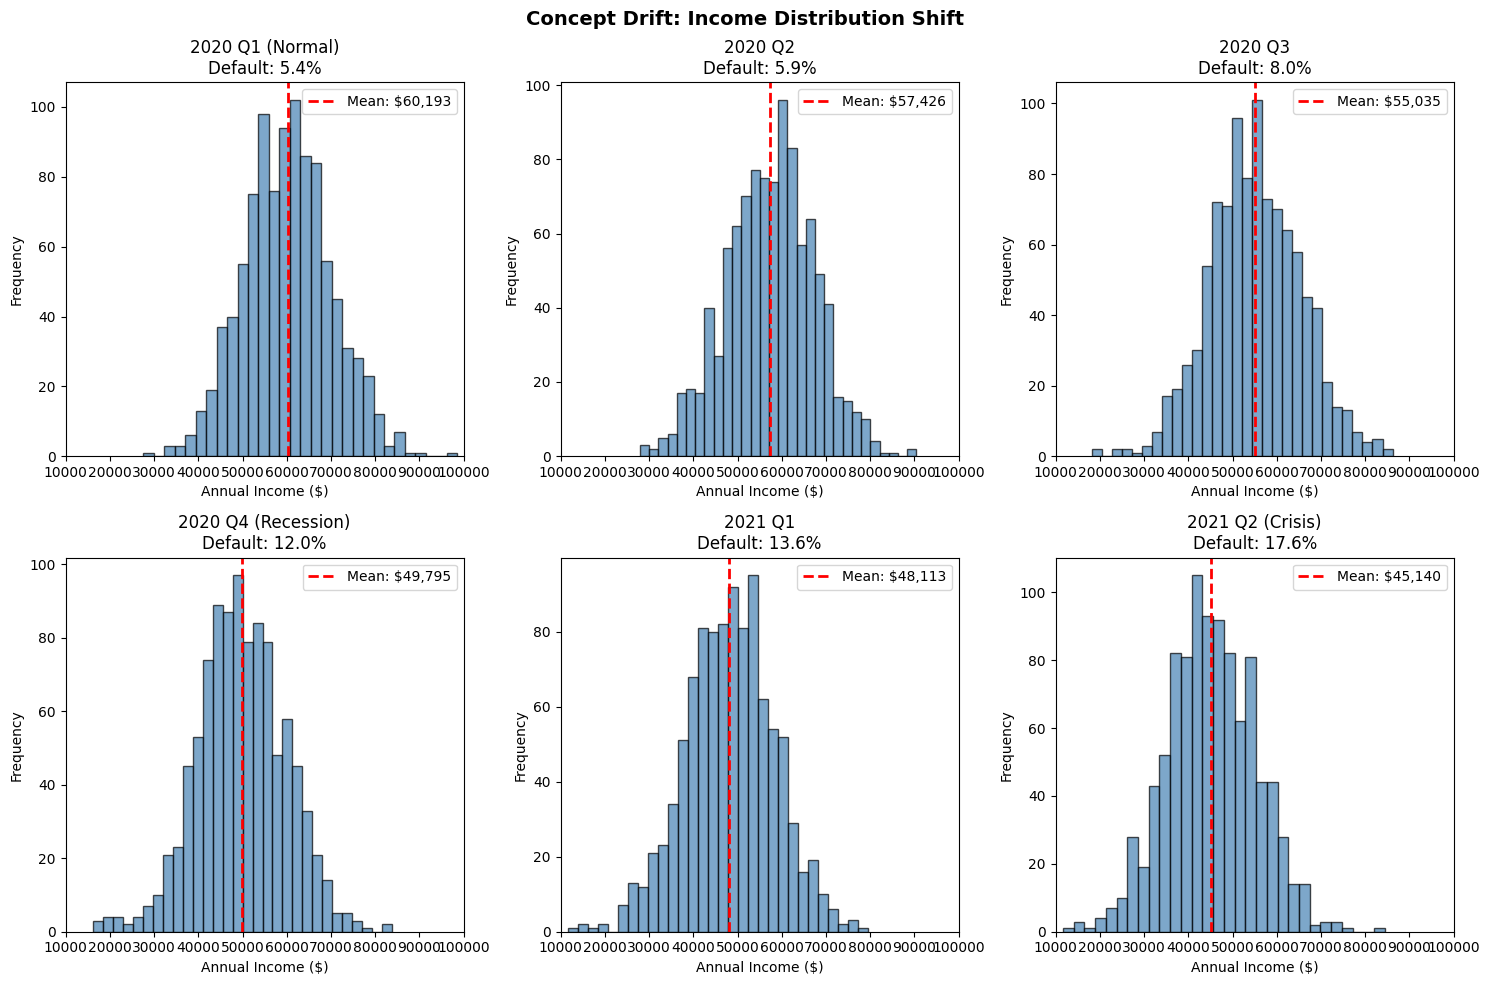

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, data in zip(axes, period_data):
    ax.hist(data['income'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(data['income'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: ${data['income'].mean():,.0f}")
    ax.set_xlabel('Annual Income ($)')
    ax.set_ylabel('Frequency')
    default_rate = data['y'].mean() * 100
    ax.set_title(f"{data['name']}\nDefault: {default_rate:.1f}%")
    ax.legend()
    ax.set_xlim(10000, 100000)

plt.suptitle('Concept Drift: Income Distribution Shift', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../output/Q3/concept_drift_simulation.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. PSI (Population Stability Index)

In [ ]:
def calculate_psi(expected, actual, bins=10):
    breakpoints = np.percentile(expected, np.linspace(0, 100, bins + 1))
    breakpoints[0] = -np.inf
    breakpoints[-1] = np.inf
    
    expected_counts = np.histogram(expected, breakpoints)[0]
    actual_counts = np.histogram(actual, breakpoints)[0]
    
    expected_pct = expected_counts / len(expected)
    actual_pct = actual_counts / len(actual)
    
    expected_pct = np.where(expected_pct == 0, 0.0001, expected_pct)
    actual_pct = np.where(actual_pct == 0, 0.0001, actual_pct)
    
    psi = np.sum((actual_pct - expected_pct) * np.log(actual_pct / expected_pct))
    return psi, expected_pct, actual_pct, breakpoints

baseline_income = period_data[0]['income']

print("PSI Analysis (Reference: 2020 Q1)")
print("-" * 50)

psi_results = []
for data in period_data:
    psi, _, _, _ = calculate_psi(baseline_income, data['income'])
    status = "Stable" if psi < 0.1 else ("Monitor" if psi < 0.25 else "Retrain")
    print(f"{data['name']:20s} | PSI = {psi:.4f} | {status}")
    psi_results.append({'period': data['name'], 'psi': psi})

PSI Analysis (Reference: 2020 Q1)
--------------------------------------------------
2020 Q1 (Normal)     | PSI = 0.0000 | Stable
2020 Q2              | PSI = 0.0773 | Stable
2020 Q3              | PSI = 0.2536 | Retrain
2020 Q4 (Recession)  | PSI = 1.0200 | Retrain
2021 Q1              | PSI = 1.3238 | Retrain
2021 Q2 (Crisis)     | PSI = 1.9749 | Retrain


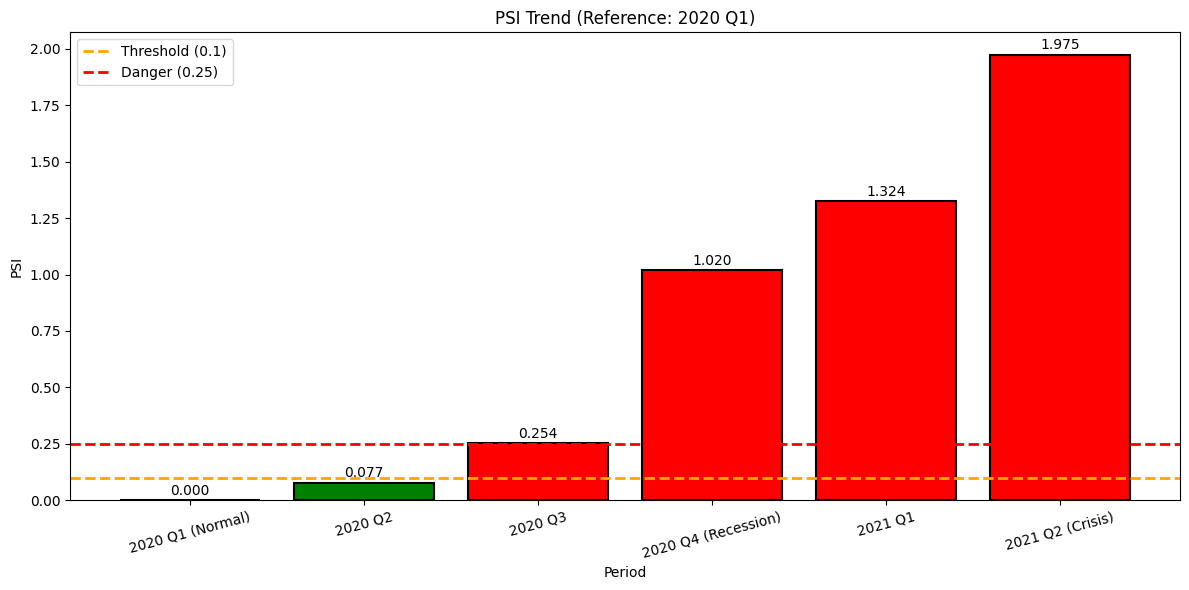

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

periods_names = [r['period'] for r in psi_results]
psi_values = [r['psi'] for r in psi_results]

colors = ['green' if p < 0.1 else 'orange' if p < 0.25 else 'red' for p in psi_values]
bars = ax.bar(periods_names, psi_values, color=colors, edgecolor='black', linewidth=1.5)

ax.axhline(y=0.1, color='orange', linestyle='--', linewidth=2, label='Threshold (0.1)')
ax.axhline(y=0.25, color='red', linestyle='--', linewidth=2, label='Danger (0.25)')

ax.set_xlabel('Period')
ax.set_ylabel('PSI')
ax.set_title('PSI Trend (Reference: 2020 Q1)')
ax.legend(loc='upper left')
ax.tick_params(axis='x', rotation=15)

for bar, val in zip(bars, psi_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../output/Q3/psi_trend.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. CSI (Characteristic Stability Index)

In [ ]:
def calculate_csi(expected_data, actual_data, feature_names, bins=10):
    csi_results = []
    for i, name in enumerate(feature_names):
        psi, _, _, _ = calculate_psi(expected_data[:, i], actual_data[:, i], bins)
        csi_results.append({'feature': name, 'csi': psi})
    return pd.DataFrame(csi_results)

feature_names = ['Annual Income', 'Age', 'Debt Ratio']
baseline_X = period_data[0]['X']
latest_X = period_data[-1]['X']

csi_df = calculate_csi(baseline_X, latest_X, feature_names)
csi_df['status'] = csi_df['csi'].apply(lambda x: 'Stable' if x < 0.1 else ('Monitor' if x < 0.25 else 'Risk'))

print("CSI Analysis (2020 Q1 vs 2021 Q2)")
print(csi_df.to_string(index=False))

CSI Analysis (2020 Q1 vs 2021 Q2)
      feature      csi status
Annual Income 1.974862   Risk
          Age 0.011481 Stable
   Debt Ratio 0.018613 Stable


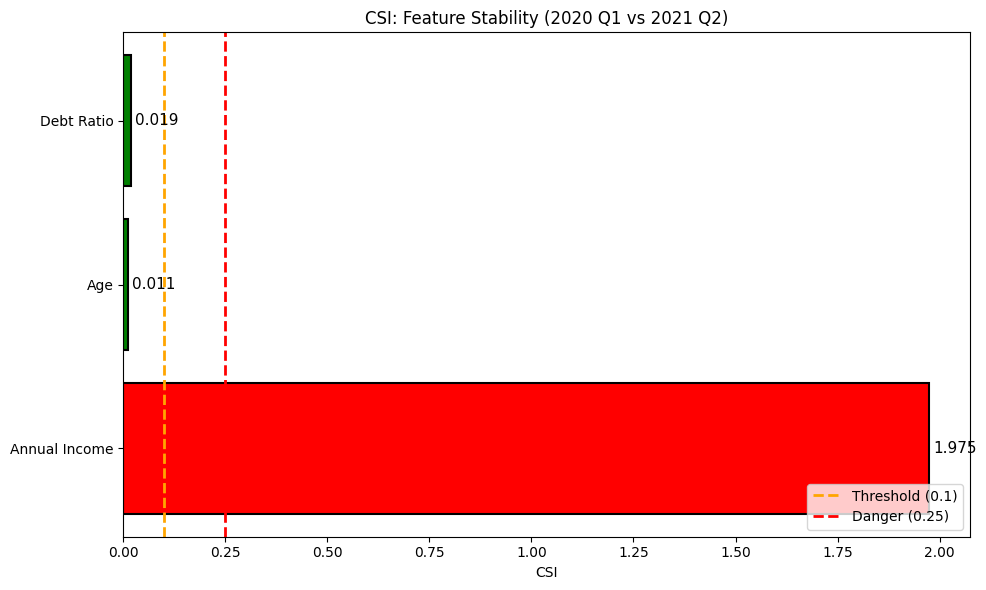

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['green' if c < 0.1 else 'orange' if c < 0.25 else 'red' for c in csi_df['csi']]
bars = ax.barh(csi_df['feature'], csi_df['csi'], color=colors, edgecolor='black', linewidth=1.5)

ax.axvline(x=0.1, color='orange', linestyle='--', linewidth=2, label='Threshold (0.1)')
ax.axvline(x=0.25, color='red', linestyle='--', linewidth=2, label='Danger (0.25)')

ax.set_xlabel('CSI')
ax.set_title('CSI: Feature Stability (2020 Q1 vs 2021 Q2)')
ax.legend(loc='lower right')

for bar, val in zip(bars, csi_df['csi']):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', ha='left', va='center', fontsize=11)

plt.tight_layout()
plt.savefig('../output/Q3/csi_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Model Performance Degradation

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(period_data[0]['X'], period_data[0]['y'])

print("Performance Degradation (2020 Q1 Model)")
print("-" * 50)

performance_results = []
for data in period_data:
    y_pred = model.predict(data['X'])
    y_prob = model.predict_proba(data['X'])[:, 1]
    
    auc = roc_auc_score(data['y'], y_prob)
    f1 = f1_score(data['y'], y_pred)
    
    print(f"{data['name']:20s} | AUC: {auc:.4f} | F1: {f1:.4f}")
    performance_results.append({'period': data['name'], 'auc': auc, 'f1': f1})

Performance Degradation (2020 Q1 Model)
--------------------------------------------------


2020 Q1 (Normal)     | AUC: 0.9823 | F1: 0.0714
2020 Q2              | AUC: 0.4798 | F1: 0.0000
2020 Q3              | AUC: 0.5268 | F1: 0.0000
2020 Q4 (Recession)  | AUC: 0.5728 | F1: 0.0000
2021 Q1              | AUC: 0.5377 | F1: 0.0000
2021 Q2 (Crisis)     | AUC: 0.5332 | F1: 0.0000


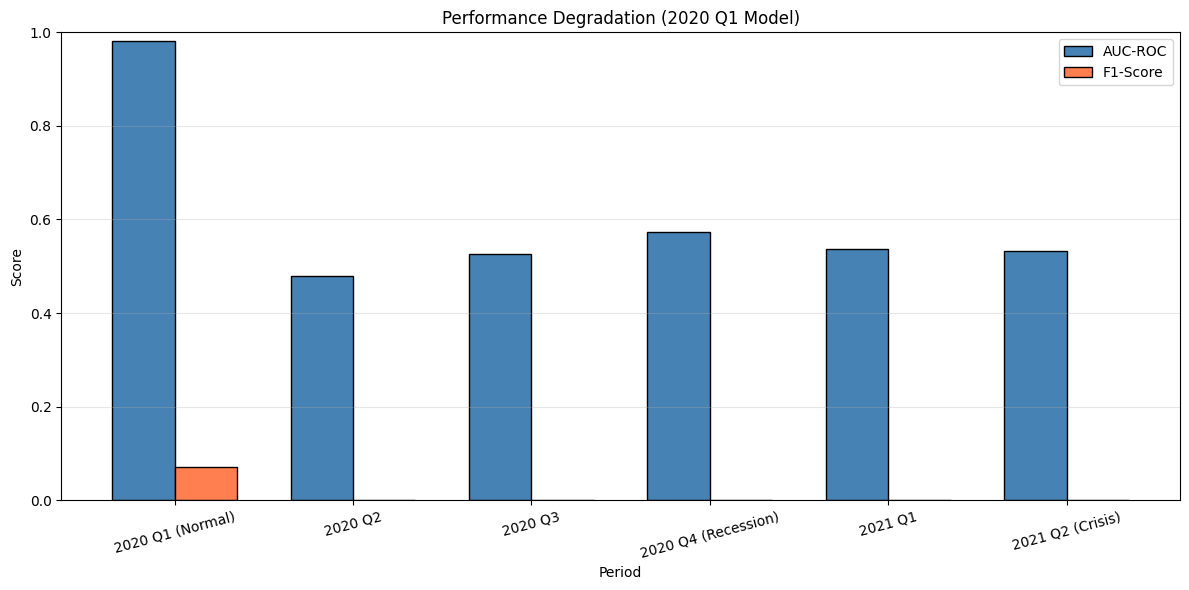

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

periods_plot = [r['period'] for r in performance_results]
auc_values = [r['auc'] for r in performance_results]
f1_values = [r['f1'] for r in performance_results]

x = np.arange(len(periods_plot))
width = 0.35

ax.bar(x - width/2, auc_values, width, label='AUC-ROC', color='steelblue', edgecolor='black')
ax.bar(x + width/2, f1_values, width, label='F1-Score', color='coral', edgecolor='black')

ax.set_xlabel('Period')
ax.set_ylabel('Score')
ax.set_title('Performance Degradation (2020 Q1 Model)')
ax.set_xticks(x)
ax.set_xticklabels(periods_plot, rotation=15)
ax.legend(loc='upper right')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../output/Q3/performance_degradation.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Model Monitoring System

In [ ]:
class ModelMonitor:
    def __init__(self, baseline_X, baseline_y, model, psi_threshold=0.25, performance_threshold=0.1):
        self.baseline_X = baseline_X
        self.baseline_y = baseline_y
        self.model = model
        self.psi_threshold = psi_threshold
        self.performance_threshold = performance_threshold
        
        y_prob = model.predict_proba(baseline_X)[:, 1]
        self.baseline_auc = roc_auc_score(baseline_y, y_prob)
        
    def check_drift(self, new_X):
        psi_values = []
        for i in range(self.baseline_X.shape[1]):
            psi, _, _, _ = calculate_psi(self.baseline_X[:, i], new_X[:, i])
            psi_values.append(psi)
        return {'max_psi': max(psi_values), 'avg_psi': np.mean(psi_values), 'drift_detected': max(psi_values) > self.psi_threshold}
    
    def check_performance(self, new_X, new_y):
        y_prob = self.model.predict_proba(new_X)[:, 1]
        current_auc = roc_auc_score(new_y, y_prob)
        degradation = (self.baseline_auc - current_auc) / self.baseline_auc
        return {'baseline_auc': self.baseline_auc, 'current_auc': current_auc, 'degradation': degradation, 'retrain_needed': degradation > self.performance_threshold}
    
    def full_check(self, new_X, new_y, period_name=""):
        drift_result = self.check_drift(new_X)
        perf_result = self.check_performance(new_X, new_y)
        needs_retrain = drift_result['drift_detected'] or perf_result['retrain_needed']
        return {'period': period_name, 'drift': drift_result, 'performance': perf_result, 'action': 'Retrain' if needs_retrain else 'OK'}

In [ ]:
monitor = ModelMonitor(
    baseline_X=period_data[0]['X'],
    baseline_y=period_data[0]['y'],
    model=model,
    psi_threshold=0.25,
    performance_threshold=0.1
)

print("Monitoring System Results")
print("-" * 50)

for data in period_data:
    result = monitor.full_check(data['X'], data['y'], data['name'])
    print(f"{result['period']}")
    print(f"  PSI (max): {result['drift']['max_psi']:.4f}")
    print(f"  AUC drop: {result['performance']['degradation']*100:.1f}%")
    print(f"  Action: {result['action']}")
    print()

Monitoring System Results
--------------------------------------------------
2020 Q1 (Normal)
  PSI (max): 0.0000
  AUC drop: 0.0%
  Action: OK



2020 Q2
  PSI (max): 0.0773
  AUC drop: 51.2%
  Action: Retrain

2020 Q3
  PSI (max): 0.2536
  AUC drop: 46.4%
  Action: Retrain

2020 Q4 (Recession)
  PSI (max): 1.0200
  AUC drop: 41.7%
  Action: Retrain

2021 Q1
  PSI (max): 1.3238
  AUC drop: 45.3%
  Action: Retrain

2021 Q2 (Crisis)
  PSI (max): 1.9749
  AUC drop: 45.7%
  Action: Retrain

